# Laboratory #5_2 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

### Done by Armando Rodriguez Ramos and Hasnain Shafqat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import packages

In [ ]:
# Package only used for coloring the labels
! pip install distinctipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from tensorflow import keras
from keras import layers
from distinctipy import distinctipy
from keras.utils import load_img
from PIL.ImageOps import autocontrast
from sklearn.metrics import jaccard_score

## Set paths

In [ ]:
HussPath = '/content/drive/MyDrive/MAI/Q1/CV/5_2/'
ArmandoPath = '/content/drive/MyDrive/UNIVERSITAT/Master/1-1/CV/LabsCV/5_2/'

# Use the path where your data folder is located
root_path = ArmandoPath

## Define classes colors

In [ ]:
random_state = 42

In [ ]:
numberClasses = 42 # Without considering black
colors = distinctipy.get_colors(numberClasses, rng=random_state)
colors.insert(0,(0,0,0)) # Add black to the blackground
classes = pd.read_csv(root_path+'TrayDataset/classes.csv')
classes["color"] = colors

## Auxiliar functions

In [ ]:
def plot_images(images, size=(10,10), width=0, height=0, limits=[], titles=[], paths=[], autocontrasts=[]):
  assert len(images) == len(limits) or limits == [], "Define a number of limits according to the number of images"
  assert len(images) == len(paths) or paths == [], "Define a number of paths according to the number of images"
  assert len(images) == len(autocontrasts) or autocontrasts == [], "Define a number of autocontrasts according to the number of images"

  if not width : width  = len(images)
  if not height: height = 1
  fig, axs = plt.subplots(height,width,figsize=size)
  for idx,image in enumerate(images):
    if width != 1 and height != 1:
      axs = axs.flatten()
    ax = axs if width == 1 and height == 1 else axs[idx]
    lim = limits[idx] if limits != [] else (None,None)
    title = titles[idx] if titles != [] else None
    path = paths[idx] if paths != [] else None
    auto = autocontrasts[idx] if autocontrasts != [] else None

    if path: image = load_img(image)
    if auto: image = autocontrast(image)
    
    ax.imshow(image, vmin = lim[0], vmax = lim[1])
    ax.set_title(title)
    ax.set_xticks([]); 
    ax.set_yticks([])
  plt.show()

In [ ]:
def fromMaskToColor(mask):
  newMask = None
  if mask.shape[-1] == 3: # color
    newMask = np.zeros_like(mask)
  else: #grayscale
    newMask = np.zeros((mask.shape[0],mask.shape[1],3))
  
  labels = []
  for index, row in classes.iterrows():
    indices = np.argwhere(mask == row["_id"])
    if len(indices) != 0:
      newMask[indices[:,0],indices[:,1]] = row["color"]
      labels.append((row["_name"],row["color"]))

  return newMask, labels

In [ ]:
def plot_segmentations(image, mask, titles, size=(20,10)):
  fig, axs = plt.subplots(1, 3, figsize=size)
  axs = axs.flatten()

  axs[0].imshow(image)
  axs[0].set_title(titles[0])
  axs[0].set_xticks([]); axs[0].set_yticks([])

  maskCopy = mask.copy()
  maskCopy, labels = fromMaskToColor(maskCopy)

  axs[1].imshow(maskCopy)
  axs[1].set_title(titles[1])
  axs[1].set_xticks([]); axs[1].set_yticks([])

  axs[2].imshow(image)
  axs[2].imshow(maskCopy, alpha=0.5)
  axs[2].set_title(titles[2])
  axs[2].set_xticks([]); axs[2].set_yticks([])

  handles = []
  for label, color in labels:
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

  plt.legend(handles=handles, loc='upper center', 
             bbox_to_anchor=(1.6, 0.75), ncol=2,
             fancybox=True, shadow=True)
  plt.show()

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
train_img = os.path.join(root_path, 'TrayDataset/XTrain')
train_mask = os.path.join(root_path, 'TrayDataset/yTrain')
test_img = os.path.join(root_path, 'TrayDataset/XTest')
test_mask = os.path.join(root_path, 'TrayDataset/yTest')

*   Define the constants needed for training the model

In [ ]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [ ]:
train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

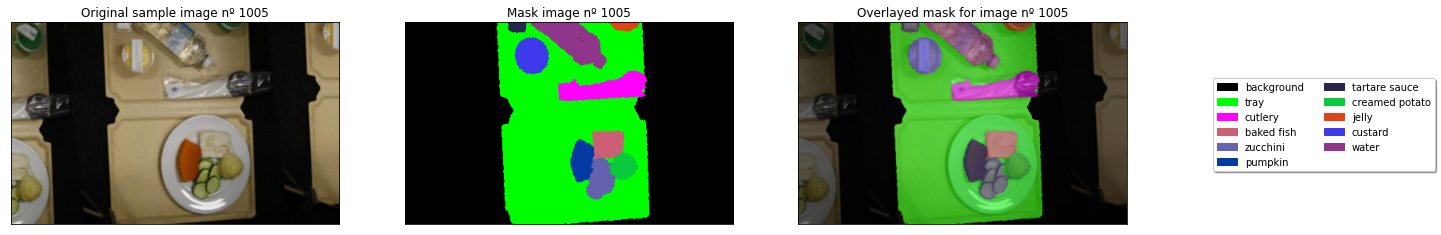

In [ ]:
imageIdx = random.randint(0,len(train_img_paths)-1)
image = np.array(load_img(train_img_paths[imageIdx]))
mask = np.array(load_img(train_mask_paths[imageIdx], color_mode="grayscale"))
titles = [f"Original sample image nº {imageIdx}",f"Mask image nº {imageIdx}",f"Overlayed mask for image nº {imageIdx}"]
plot_segmentations(image, mask, titles=titles)

> Here we can see a sample image with its corresponding mask and this last one overlayed in front of the original image. We can see that some of the food is being segmented while (in some random images) some of the food is not located.

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [ ]:
class ImageGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

> This image generator reads images of a specific size (img_size) from the given input and target paths and returns batches of tuples of images and targets. This generator is nearly identical to the one in the tutorial, but it did not extract one from the target images.

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

> This model is entirely extracted from the tutorial.\
We can see that it is a U-Net, with the first part being a contraction phase followed by the second, an expansion phase.

In [ ]:
keras.backend.clear_session()
model = get_model(img_size, num_classes)

*   Print the summary of the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

> We can see that the model has a lot of layers. Some of them are convolutional layers, which intercalate with batch normalization, max_pooling for the contraction phase, up_sampling for the expansion phase, and activation layers, among others. It has to be mentioned that this is quite a big model with a total of 2 million parameters, most of them having to be trained.

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [ ]:
random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

*   Train the model using fit method

> We have saved the model as "imageSegmentationModel.h5". If you want to retrain the model, set train to true and load to false to use the trained model. This new model can also be saved if the save boolean indicates so.

In [ ]:
train, save, load = False, False, True
saveLoadPath = root_path+'imageSegmentationModel.h5'

if train:
  print("Train model...", end="")
  model.fit(train_gen, epochs=15, validation_data=val_gen, callbacks=callbacks)
  print("Done!")
if train and save:
  print("Save model...", end="")
  model.save(saveLoadPath)
  print("Done!")
if load:
  print("Loading model...", end="")
  model = keras.models.load_model(saveLoadPath)
  print("Done!")

Loading model...Done!


# Visualize predictions

*   Generate predictions for all images in the validation set
*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.
*   Read the test mask images to create the ground truth

In [ ]:
batch_size = 1  # we define batch_size as 1 for inferencing
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [ ]:
val_images = []
val_masks = []
val_images_pred = []
for val_image, val_mask in val_gen:
  val_images.append(val_image[0].astype("int"))
  val_masks.append(val_mask[0].squeeze())
  pred = model.predict(val_image)
  val_images_pred.append(pred[0])

val_images = np.array(val_images)
val_masks = np.array(val_masks)
val_images_pred = np.array(val_images_pred)

# Compute tha maximum value of last axis to get the predicted mask
val_masks_pred = np.argmax(val_images_pred, axis=-1)

print("Images shape", val_images.shape)
print("Masks shape", val_masks.shape)
print("Predictions shape", val_images_pred.shape)
print("Predictions masks shape", val_masks_pred.shape)

1/1 [==============================] - 0s 28ms/step
Images shape (8, 160, 160, 3)
Masks shape (8, 160, 160)
Predictions shape (8, 160, 160, 43)
Predictions masks shape (8, 160, 160)


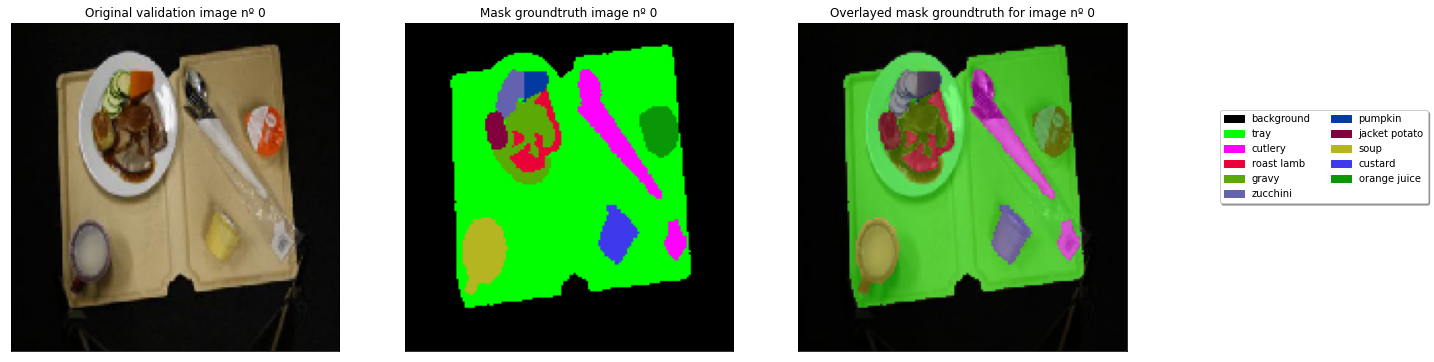

In [ ]:
imageIdx = 0 # First image
titles = [f"Original validation image nº {imageIdx}",f"Mask groundtruth image nº {imageIdx}",f"Overlayed mask groundtruth for image nº {imageIdx}"]
plot_segmentations(val_images[imageIdx], val_masks[imageIdx], titles=titles)

> We can see that the ground truth mask has a lot of interesting parts where food is being correctly segmented. This image contains 11 different colors, ranging from the black background to the orange juice in dark green, passing through the cuttlery or the soup.

*   For each validation image, find the jaccard similarity score

In [ ]:
averages = ['micro', 'macro', 'samples', 'weighted', 'binary', None]

print("Jaccard similarity coefficient score:")
for average in averages:
  print(" Average =",average)
  for imageIdx, (val_mask, val_mask_pred) in enumerate(zip(val_masks, val_masks_pred)):
    try:
      jaccard = jaccard_score(val_mask.flatten(), val_mask_pred.flatten(), average=average)
    except:
      print("  Not possible to use average =", average)
      break
    print(f"  Image {imageIdx+1} =", jaccard)

Jaccard similarity coefficient score:
 Average = micro
  Image 1 = 0.817923590399091
  Image 2 = 0.9463240325401049
  Image 3 = 0.7516250427642833
  Image 4 = 0.9477308175143607
  Image 5 = 0.8263537133480774
  Image 6 = 0.8552741239989854
  Image 7 = 0.8587090684672911
  Image 8 = 0.9495849516411545
 Average = macro
  Image 1 = 0.41490911437650224
  Image 2 = 0.8423212113582805
  Image 3 = 0.2437052871993086
  Image 4 = 0.8246175632944776
  Image 5 = 0.34275308751878286
  Image 6 = 0.552177862354996
  Image 7 = 0.45830306471678944
  Image 8 = 0.8533780527113942
 Average = samples
  Not possible to use average = samples
 Average = weighted
  Image 1 = 0.855585505041654
  Image 2 = 0.9473588514826423
  Image 3 = 0.7777418924450176
  Image 4 = 0.9505766335636906
  Image 5 = 0.8475730483672702
  Image 6 = 0.8650385207975211
  Image 7 = 0.864164571561474
  Image 8 = 0.9510056576283005
 Average = binary
  Not possible to use average = binary
 Average = None
  Image 1 = [0.9771345  0.8435737

*   **What do you understand from the 'average' parameter of the Jaccard similarity score function?**

> The average parameter of the Jaccard is the one that indicates the type of averaging performed on the data. If None of the averages is performed we can see that we obtain an array instead of a single value.

*   **What are the different values of 'average' parameter?**

> There are five main types of averaging methods.
- Micro: Calculate metrics globally by counting the total true positives, false negatives, and false positives. With this averaging method, we obtain quite good results in the Jaccard scores.
- Macro: Calculate metrics for each label and find their unweighted mean. With this average, the score decreases quite a lot in some of the images, as, for example, in image 5, with only 0.34 of a score.
- Samples: Calculate metrics for each instance and find their average. With the samples' metric, we obtain an error.
- Weighted: Average the metrics for each label, weighted by support (the number of true instances for each label). We get good results with this one, as well as the micro one.
- Binary: Only report results for the class specified by pos_label. The binary averaging didn't apply to our data.

> We can see that using the "micro" and "weighted" averaging methods, we are said to obtain really good results. However, other metrics, such as the "macro" which takes into account the label imabalance, didn't seem to agree on the excessive correctness of the results.

*   **Which parameter is used for what type of problem?**

>  There are several options, and each one of those is used for specific problems.
- Micro: This is the most commonly used; it computes the average metric globally.
- Macro: This one didn't take into account label imbalance.
- Samples: This one is only meaningful for mutilabel classification problems.
- Weighted: This alters or "corrects" the macro to account for label imbalance.
- Binary: This one is used only with binary data, i.e., if targets (y_{true,pred}) are binary.

All the information about this three questions were extracted from sklearn jaccard_score [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html).

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

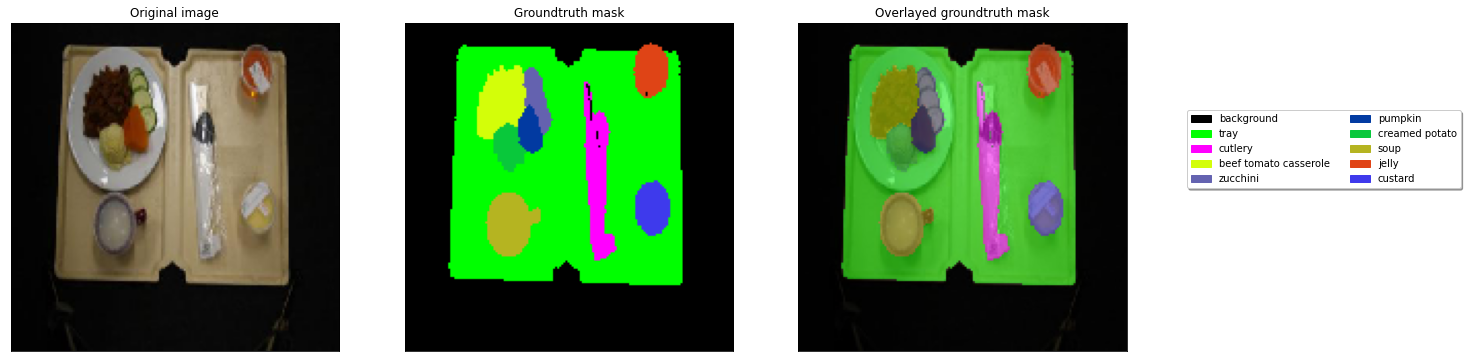

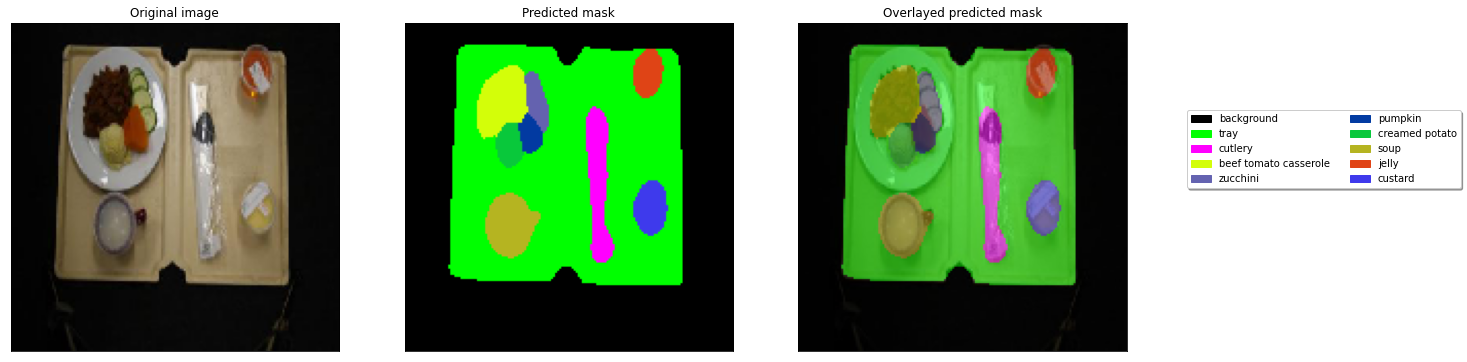

In [ ]:
randomIdx = random.randint(0,len(val_images)-1)
val_image = val_images[randomIdx].astype('int')
val_mask = val_masks[randomIdx]
val_image_mask_pred = val_masks_pred[randomIdx]

titles = ["Original image", "Groundtruth mask", "Overlayed groundtruth mask"]
plot_segmentations(val_image, val_mask, titles)

titles = ["Original image", "Predicted mask", "Overlayed predicted mask"]
plot_segmentations(val_image, val_image_mask_pred, titles)

> We can see how all the elements located in the ground truth are being correctly found, segmented, and classified in the prediction mask. This shows the correctness of the model with images similar to the ones it was trained with.

*   **What are other evaluation metrics to compare the performance of segmentation?**

> This question is really similar to one answered in the previous laboratory session. As a result, we will use the previously searched information to answer this question. There are several options that could be considered, but the most simple and commonly used ones are, for example:
*   **Pixel Accuracy:** Pixel accuracy is the percentage of pixels in your image that are correctly classified, and it is very similar to normal accuracy. The formula is the following one: $\text{pixel accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$ which is basically the number of correct pixels divided by the total. And as with classification accuracy, pixel accuracy experiences the same issues. The issue with pixel accuracy is that if a class, such as the background of the image, constitutes 90% of the image, our segmentation may recognize it correctly and provide us with a whopping pixel accuracy of 90%. However, this would be deceptive because we might not segment correctly the remaining 10% of the images and believe we got excellent segmentation. This issue is called class imbalance. To solve this, we can use other metrics such as the Jaccard index and the dice coefficient.
*   **Intersection-Over-Union (Jaccard Index):** The Jaccard index, also referred to as the intersection over union, will be the next metric we explore (IoU). The IoU is defined as the area of union between the predicted segmentation and the ground truth, divided by the area of overlap between the predicted segmentation and the ground truth. Due to the fact that it analyzes more information than accuracy does, implying that it is a lot more expensive to run or complicated to code algorithmically, this metric resolves the issue of not recognizing the class imbalance in the image segmentation.
*   **Dice Coefficient (F1 Score):** The dice coefficient is equal to $2*\frac{\text{overlap area}}{\text{total number of pixels}}$ in both images. The IoU and the dice coefficient are quite similar. They are positively associated, so if one claims that model A is superior to model B at picture segmentation, the other will also claim the same. They both have a range from 0 to 1, with 1 denoting the highest resemblance between the expected and truth, akin to the IoU.

> Information extracted from [reference](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2). Apart from these metrics, we have others such as precision, recall, etc. However, we think that the ones we explained previously are the most commonly used.

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

1/1 [==============================] - 0s 21ms/step


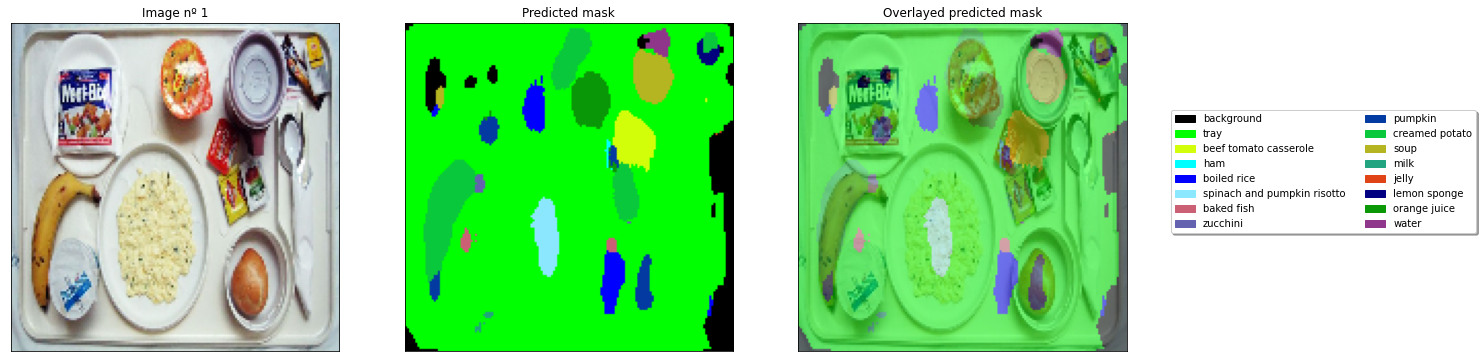

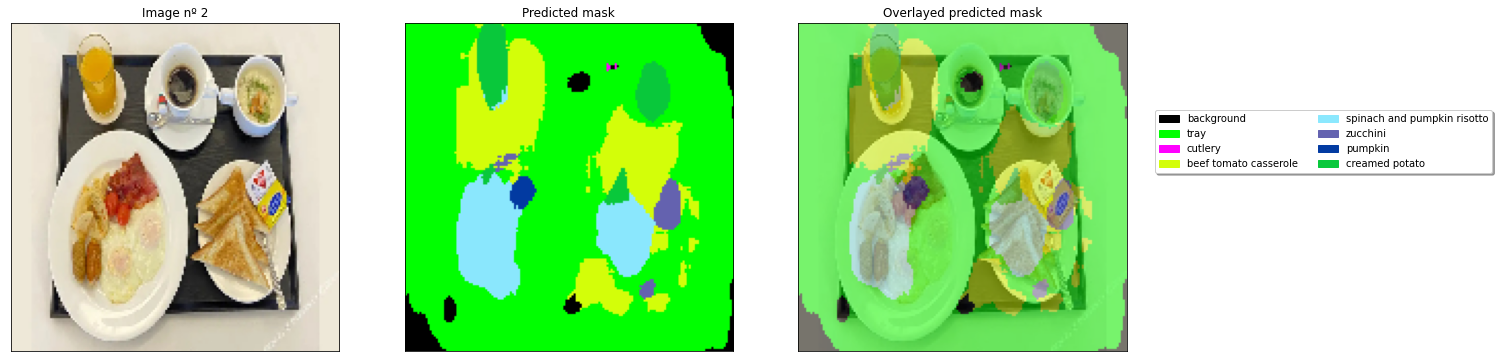

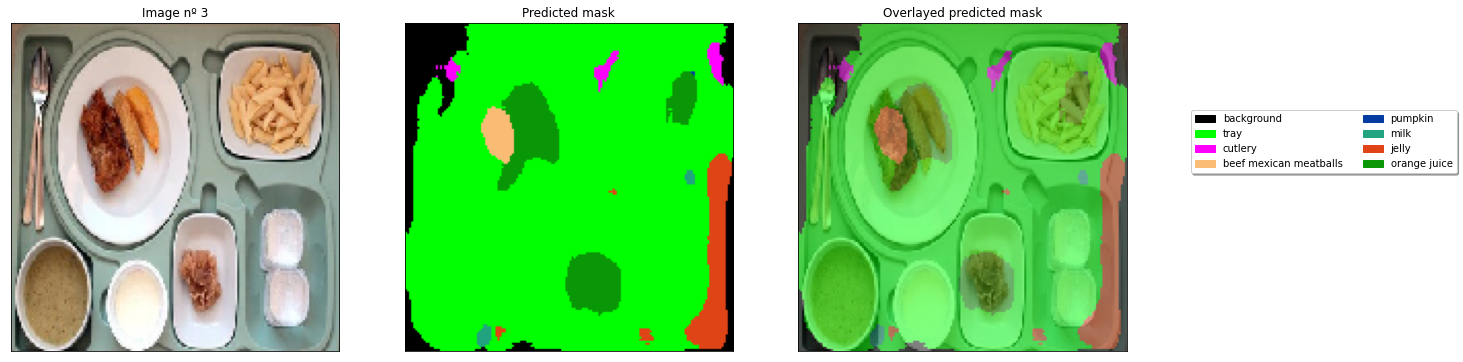

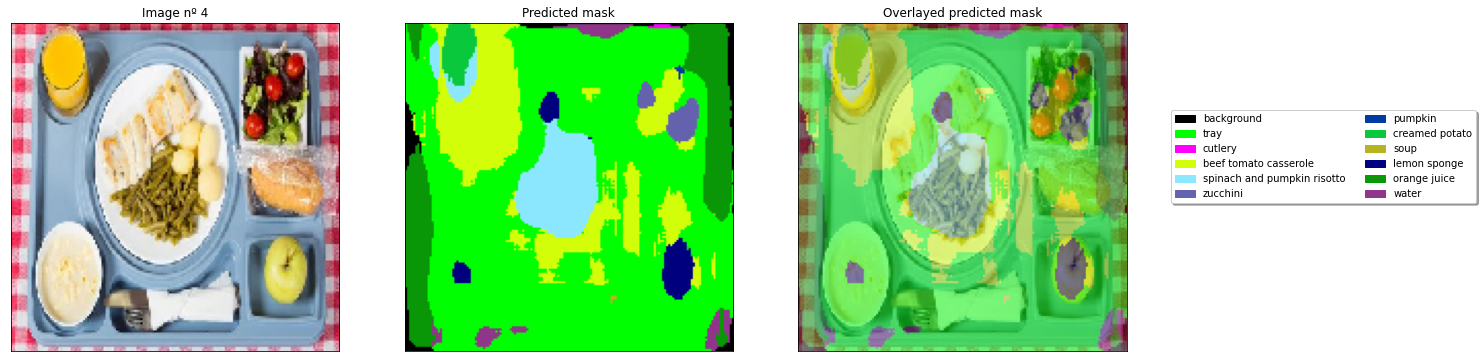

In [ ]:
sample_images_path = root_path+"sampleImages/"
sampleImages = []
for fname in sorted(os.listdir(sample_images_path)):
    image = load_img(sample_images_path+fname, target_size=img_size)
    sampleImages.append(np.array(image))
sampleImages = np.array(sampleImages)
predictions = model.predict(sampleImages)

for i, (image, prediction) in enumerate(zip(sampleImages, predictions)):
  titles = [f"Image nº {i+1}", "Predicted mask", "Overlayed predicted mask"]
  mask =  np.argmax(prediction, axis=-1)
  plot_segmentations(image, mask, titles=titles)

*   **How accurate are the prediction masks?**

> After analyzing in detail the previous images and their respective masks, we can see that the results are quite improveable. We can see that the model has clear difficulties while trying to segment all the models. The images with the best mask are images 1 and 5. However, when compared to the test dataset results, the masks are highly improveable. We can appreciate that even though the model tries to detect all the objects in the images, the labels assigned are incorrect because we have objects that don't appear in the train data, which leads to misclassified labels. One example can be seen in image 1, where banana is classified as "creamy potato". The main reason for this is that the train dataset doesn't have enough samples and labels to represent all the possible objects that can be in a food tray. Moreover, the internet has a large number of images, which generate a lot of variable data, so performing on all of them would be a challenging task for any model. Hence, we think that this result was predictable and is completely normal.

*   **What happens to the unlabelled classes?**

> When our model attempts to classify unlabeled classes, it occasionally encounters a similar shape and misclassifies. For instance, in image no. 1, we have a banana on the plate, and as we know, the banana class is not on our train dataset. In this sample, the models determine that the banana is a creamed paste with no meaning. So we can appreciate that it may fail and classify an unlabeled class into something totally opposite. It would be more understandable if it were classified as something like pickles, which have a similar shape. Moreover, our model struggles even with labeled classes. For example, our model trained with the apple class, but it is very difficult for it to classify correctly. In addition, we have other classes like cuttlery, which also can't be detected in any of the sample images. We can appreciate that our model has problems even with labeled classes. Hence, it is perfectly understandable that it always misclassifies or doesn't even find anything in the unlabeled classes because it has never seen them.

*   **What are the challenges when you use a trained model in the wild?**

> There are a wide number of challenges when we use a trained model in the wild. First of all, due to the huge intraclass variations, we have difficulties detecting the same object even if we have 1000 samples about it. Hence, sometimes we will not be able to detect some objects even if they are available in the training dataset. A similar problem happens due to the similarities between classes. For instance, a pack of yogurt and a pack of butter are very similar, which may confuse our model. This is due to the fact that even if they are different classes, there are many similarities between them because the packing is similar.
Moreover, some times the food is mixed with or overlaps other food pieces, which leads the model to not detect them correctly. Furthermore, there are other challenges, such as the point of view of the image, the quality of the image, and many more. We can appreciate that creating a model that performs well in the wild is highly difficult because the number of problems is extremely high.

*   **How can you develop a model to be used in real world?**

> Creating a model to be used in the real world is not an easy task. However, if we had to build a model that worked in the real world, the first thing we would need is a huge dataset with a sufficient number of images. In addition, we can use this dataset and use augmentation techniques such as scaling the images, adding rotations, adding noise to the images, upsampling, etc. Our main priority should be getting the highest-variability dataset possible. The high variability will allow us to detect a large number of cases, which will improve our model's performance in the real world. As a final note, we would like to add that this is very difficult and time-consuming because the bigger the dataset, the more time it will take to train the model. 

*   **What is the difference between instance segmentation and semantic segmentation?**

> The main difference between semantic segmentation and instance segmentation is how they treat an instance of the same class in the image. On the one hand, semantic segmentation associates every pixel of an image with a class label such as "person", "road", "car", etc. It treats multiple objects of the same class as a single entity. On the other hand, instance segmentation treats multiple objects of the same class as different individual instances. Hence, as the name indicates, instance segmentation can differentiate between instances of the same class, while semantic segmentation can't. This difference can be appreciated better in the following image:

> 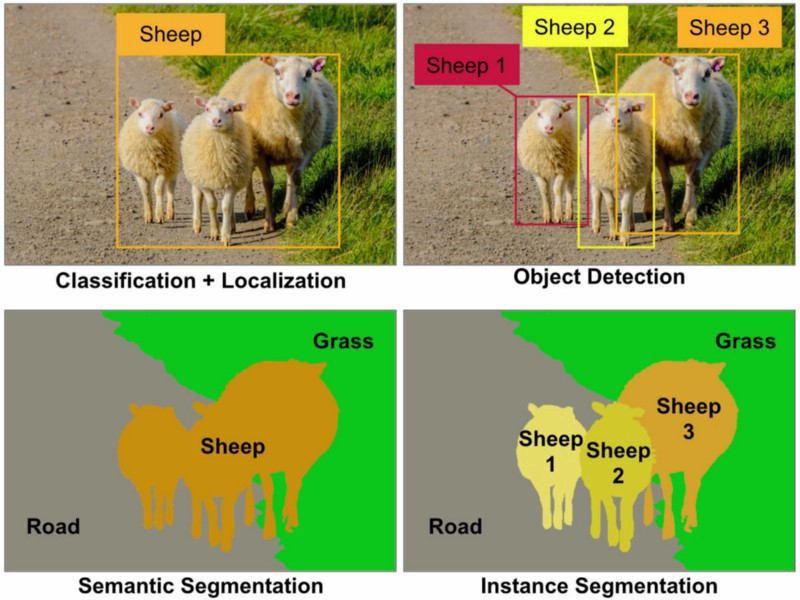

> [Image reference](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)

*  **What is the difference between encoder and decoder? Should they be of the same type of neural network?**

> The main difference between encoder and decoder is that they act in the opposite direction if we compare them. To summarize, we can say that the encoder takes the input and translates it to an intermediate state. And then, the decoder retrieves that intermediate state and transforms it into the output. Moreover, we would like to add that encoders and decoders usually work together, but they can work separately, which means that we can have models that just use one of them. \
With respect to the second question, they usually have the same type of neural network; however, they can have different structures because the intermediate state can be used by several decoders, which can lead to different networks.
In the case of the UNET, UNET is a U-shaped encoder-decoder network architecture that consists of four encoder blocks and four decoder blocks that are connected via a bridge. The encoder network acts as the feature extractor and learns an abstract representation of the input image through a sequence of encoder blocks. Moreover, the decoder network is used to take the abstract representation and generate a semantic segmentation mask. 



*   **What is upsampling?**

> Upsampling is the process of adding new synthetic data to our actual data. This may be due to the fact that we have low data or other reasons. It depends a lot on the problem we are solving. For instance, in problems related to images, upsampling adds new rows and columns to the matrix of pixels. The reason for this may be due to the fact that we need to increase the resolution of the image. An approach to adding the new columns will be to interpolate the new data between the rows and  columns, which provides a reasonably accurate intermediate value using some advanced mathematical techniques. We can use techniques like "nearest neighbor" interpolation, "bicubic spline" interpolation, "bilinear" interpolation, etc.

*   **What are feature channels in UNet? Why is this helpful in this architecture?** [Reference](https://arxiv.org/pdf/1505.04597.pdf)

> The feature channels in UNet simply mean the number of channels at a given point in the network. As we know, in a CNN, a convolutional layer receives input, transforms the input in some way, and then outputs the transformed input to the next layer. The inputs to convolutional layers are called input channels, and the outputs are called output channels. Hence, the feature channels are the same as the channels in a basic CNN, but each represents a feature of the image. The feature channels are helpful in this architecture because, in the encoder part, we double the number of feature channels after each max pooling operation. Then, in the decoder part, we start with a large number of feature channels, which allow the network to propagate context information to higher resolution layers.

*   **What are some applications of U-Net?**

> The UNet has several applications in the real world due to its versatility. First of all, we can use UNet in the creation of autonomous vehicles, which can use the semantic segmentation done to differentiate between humans, trees, roads, etc. Moreover, it can provide information about free space on the roads as well as detect lane markings and traffic signs. In addition, UNet can be used in biomedical image diagnosis. UNet can augment the analysis performed by radiologists, greatly reducing the time required to run diagnostic tests. Finally, it can also be used in satellite image segmentation. It can be used to measure deforestation, map damaged areas after a natural disaster, recover looted archaeological sites, and many more things. We can appreciate that the number of cases is high and that it can be used in a lot of fields, which means that UNet is very versatile.

*   **What are the other popular semantic segmentation algorithms? How are they different from each other?** [Reference](https://neptune.ai/blog/image-segmentation)

> There are plenty of other techniques that allow us to do semantic segmentation. We will mention two of the most popular and try to explain the main idea behind them. The two algorithms are the following ones:
* **Fully Convolutional Network (FCN)**: FCN uses various blocks of convolution and max pool layers to first decompress an image. Then it makes a class prediction with the reduced size. Finally, it uses upsampling and deconvolution layers to resize the image to its original dimensions. These models typically don’t have any fully connected layers. The goal of downsampling steps is to capture semantic and contextual information, while the goal of upsampling steps is to recover spatial information. Moreover, there are no limitations on image size. The final image is the same size as the original image.
* **Mask-RCNN**:  We know that Faster R-CNN has two outputs for each candidate object: a class label and a bounding-box offset. To this, we add a third output, which is the object mask. This object mask is a binary mask that indicates the pixels where the object is in the bounding box. But the additional mask output is distinct from the class and box outputs, requiring the extraction of a much finer spatial layout of an object. To do this, the Mask RCNN uses the Fully Convolutional Network. Hence, we can say that Mask RCNN combines the two networks, Faster RCNN and FCN, into one big architecture. Additionaly, this technique is currently the state of art for isntance segmentation. We can see it is one of the best algorithms about the segmentation problem.

*   **What are the popular semantic segmentation datasets which are available for public access?**

> There are several popular image segmentation datasets that can help us start to try other techniques:
* **Coco Dataset:** Coco is a large-scale object detection, segmentation, and captioning dataset. The dataset contains 91 classes and 80 object categories. The size of this dataset is 37.57 GB. Hence, we should be careful when training our model with this quantity of images because our model may take a lot of training time.
* **PASCAL Visual Object Classes (PASCAL VOC)**: The Pascal dataset has 9963 images that can be classified into 20 different classes. The size of this dataset is 2 GB.
* **Cityscapes Dataset**: This dataset contains images of city scenes and can be used to evaluate the performance of our model in urban scenarios.

All the previous datasets are free and can be downloaded by any user with an internet conection.


---

## **End of P5_2: Image Segmentation using UNet**
Deadline for P5_2 submission in CampusVirtual is: **Thursday, the 22nd of December, 2022**